In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pvlib import location, irradiance, solarposition
from tqdm.notebook import tqdm
import warnings

In [2]:
LAT, LON, TZ = 44.05, 122.3321, "Etc/GMT+8"  #'America/Los_Angeles'
ELEV = 50
SLOPE, ASPECT = 0.10, 180
times = pd.date_range(start="01-01-2021 00:00", end="12-31-2021 23:59", freq="H", tz=TZ)

site_location = location.Location(LAT, LON, altitude=ELEV, tz=TZ)
clearsky = site_location.get_clearsky(times)
solar_position = site_location.get_solarposition(times=times)
POA_irradiance = irradiance.get_total_irradiance(
    surface_tilt=np.arctan(SLOPE),
    surface_azimuth=ASPECT,
    dni=clearsky["dni"],
    ghi=clearsky["ghi"],
    dhi=clearsky["dhi"],
    solar_zenith=solar_position["apparent_zenith"],
    solar_azimuth=solar_position["azimuth"],
)

POA_irradiance

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2021-01-01 00:00:00-08:00,18.594825,15.948019,2.646806,2.646802,0.000003
2021-01-01 01:00:00-08:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 02:00:00-08:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 03:00:00-08:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01 04:00:00-08:00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2021-12-31 19:00:00-08:00,375.219554,348.414061,26.805493,26.805422,0.000071
2021-12-31 20:00:00-08:00,397.099531,368.727851,28.371680,28.371605,0.000075
2021-12-31 21:00:00-08:00,364.646181,338.597498,26.048683,26.048614,0.000069
2021-12-31 22:00:00-08:00,280.673422,260.634821,20.038602,20.038549,0.000053


In [3]:
def monthly_clearsky(
    lat, lon, elev, slope, aspect, start_year=1990, end_year=2021, timezone="Etc/GMT+8"
):
    if "GMT+" in timezone:
        tz_diff = int(timezone.split("GMT+")[-1])
        start_time = f"01-01-{start_year} {tz_diff:02d}:00"
        end_time = f"01-01-{end_year+1} {tz_diff-1:02d}:59"
    elif "GMT-" in timezone:
        tz_diff = int(timezone.split("GMT-")[-1])
        start_time = f"12-31-{start_year - 1} {24-tz_diff:02d}:00"
        end_time = f"01-01-{end_year} {23-tz_diff:02d}:59"
        tz_diff = -1 * tz_diff

    times = pd.date_range(start=start_time, end=end_time, freq="H", tz=timezone)
    site_location = location.Location(lat, lon, altitude=elev, tz=timezone)
    clearsky = site_location.get_clearsky(times)
    solar_position = site_location.get_solarposition(times=times)
    poa_irrad = irradiance.get_total_irradiance(
        surface_tilt=np.arctan(slope),
        surface_azimuth=aspect,
        dni=clearsky["dni"],
        ghi=clearsky["ghi"],
        dhi=clearsky["dhi"],
        solar_zenith=solar_position["apparent_zenith"],
        solar_azimuth=solar_position["azimuth"],
    )
    poa_irrad["CLEARSKY_GHI"] = clearsky["ghi"]
    poa_irrad["CLEARSKY_DNI"] = clearsky["dni"]
    poa_irrad["CLEARSKY_DHI"] = clearsky["dhi"]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        poa_irrad.index = poa_irrad.index.shift(periods=-tz_diff).to_period("M")

    monthly = poa_irrad.groupby(level=0).sum() * 3600

    return monthly

In [4]:
example = monthly_clearsky(
    47.608013, -122.335167, 100, 0.0, 0, start_year=1990, end_year=1996
)
example

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse,CLEARSKY_GHI,CLEARSKY_DNI,CLEARSKY_DHI
1990-01,2.026160e+08,1.703993e+08,3.221670e+07,3.221670e+07,0.0,2.026160e+08,5.980876e+08,3.221670e+07
1990-02,2.861164e+08,2.311961e+08,5.492037e+07,5.492037e+07,0.0,2.861164e+08,6.073395e+08,5.492037e+07
1990-03,4.961946e+08,4.040148e+08,9.217977e+07,9.217977e+07,0.0,4.961946e+08,8.183611e+08,9.217977e+07
1990-04,6.569017e+08,5.309803e+08,1.259213e+08,1.259213e+08,0.0,6.569017e+08,8.973667e+08,1.259213e+08
1990-05,8.096461e+08,6.481037e+08,1.615424e+08,1.615424e+08,0.0,8.096461e+08,9.916342e+08,1.615424e+08
...,...,...,...,...,...,...,...,...
1996-08,7.155552e+08,5.739757e+08,1.415795e+08,1.415795e+08,0.0,7.155552e+08,9.287920e+08,1.415795e+08
1996-09,5.302619e+08,4.275783e+08,1.026835e+08,1.026835e+08,0.0,5.302619e+08,8.019181e+08,1.026835e+08
1996-10,3.563293e+08,2.785556e+08,7.777370e+07,7.777370e+07,0.0,3.563293e+08,6.552592e+08,7.777370e+07
1996-11,2.062304e+08,1.574867e+08,4.874365e+07,4.874365e+07,0.0,2.062304e+08,4.978180e+08,4.874365e+07


In [5]:
def cloud_cover_correction(clearsky_ghi, cloud_cover, offset=0.35):
    ghi = clearsky_ghi * (offset + (1 - offset) * (1 - cloud_cover))
    return ghi

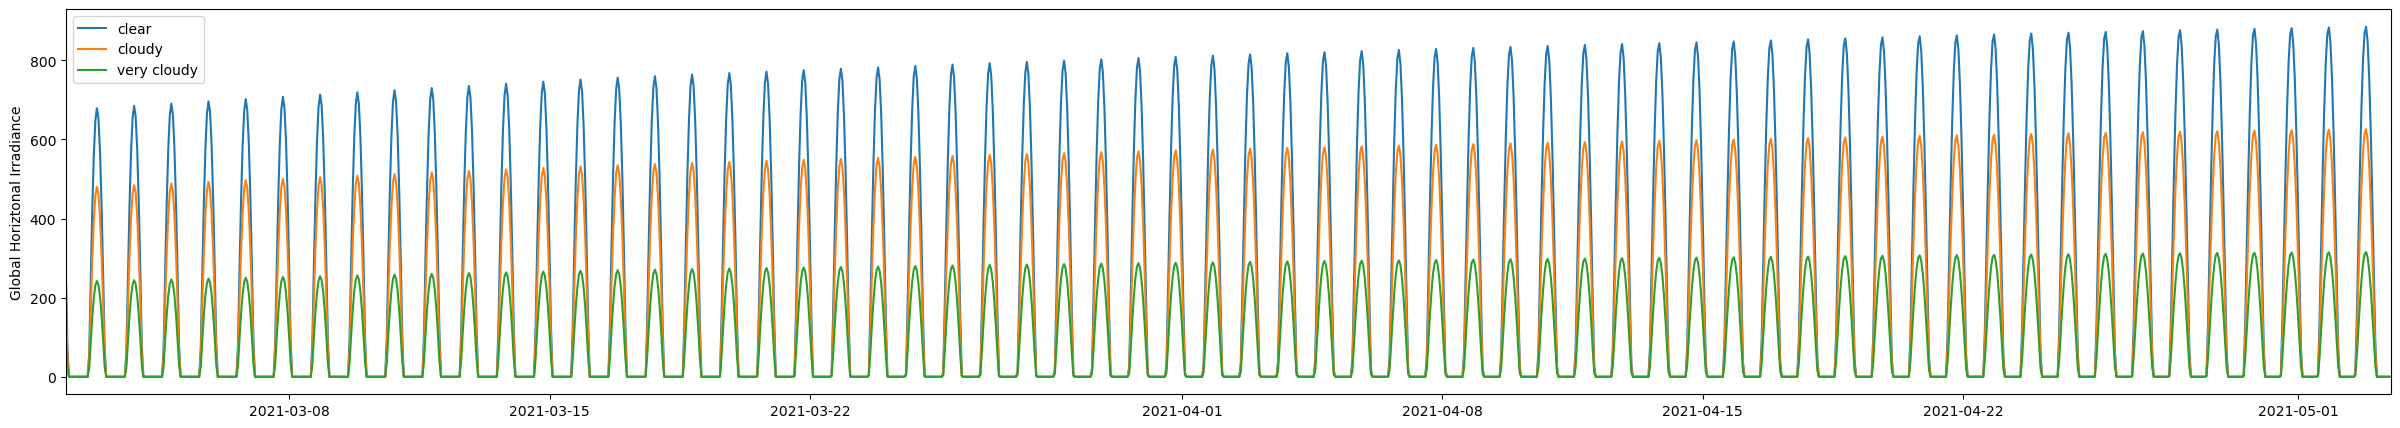

In [6]:
fig, ax = plt.subplots(figsize=(30, 5))
START_HOURS = 24 * 60
NUM_HOURS = 1500
ax.plot(
    POA_irradiance.index[START_HOURS : NUM_HOURS + START_HOURS],
    POA_irradiance.poa_global.iloc[START_HOURS : NUM_HOURS + START_HOURS],
    label="clear",
)
ax.plot(
    POA_irradiance.index[START_HOURS : NUM_HOURS + START_HOURS],
    cloud_cover_correction(
        POA_irradiance.poa_global.iloc[START_HOURS : NUM_HOURS + START_HOURS], 0.45
    ),
    label="cloudy",
)
ax.plot(
    POA_irradiance.index[START_HOURS : NUM_HOURS + START_HOURS],
    cloud_cover_correction(
        POA_irradiance.poa_global.iloc[START_HOURS : NUM_HOURS + START_HOURS], 0.99
    ),
    label="very cloudy",
)
ax.set_xlim(
    POA_irradiance.index[START_HOURS], POA_irradiance.index[START_HOURS + NUM_HOURS]
)
ax.legend()
ax.set_ylabel("Global Horiztonal Irradiance")
plt.show()

In [7]:
PLOT_DATA = "../../data/interim/plot_info_for_climatena.csv"
plots = (
    pd.read_csv(PLOT_DATA)
    .rename({"ID1": "PLOT_ID", "el": "ELEV"}, axis=1)
    .drop("ID2", axis=1)
)
plots.columns = [col.upper() for col in plots.columns]
plots = plots.set_index("PLOT_ID")
plots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LAT     12156 non-null  float64
 1   LON     12156 non-null  float64
 2   ELEV    12156 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 379.9 KB


In [8]:
TREE_DATA = "../../data/interim/FIA_remeasured_trees_for_training.csv"
trees = pd.read_csv(TREE_DATA)[["PLOT_ID", "SLOPE", "ASPECT"]]
terrain = trees.groupby(by=["PLOT_ID"])[["SLOPE", "ASPECT"]].first()
plots["ASPECT"] = terrain["ASPECT"]
plots["SLOPE"] = terrain["SLOPE"] / 100.0
# some plots had null values for ASPECT and SLOPE
# we will replace them with zeros for modeling sunlight
plots["ASPECT"].fillna(0, inplace=True)
plots["SLOPE"].fillna(0, inplace=True)
plots.head()

,LAT,LON,ELEV,ASPECT,SLOPE
PLOT_ID,,,,,
60101550679,41.806228,-123.788726,761,190.0,0.40
60101551744,41.980638,-124.193526,91,32.0,0.70
60101551969,41.681432,-123.803842,701,335.0,0.60
60101552953,41.938125,-123.870868,640,140.0,0.55
60101553315,41.738938,-123.783382,1432,137.0,0.53


In [9]:
def get_monthly_df(plot_id, start_year=1990, end_year=2021, timezone="Etc/GMT+8"):
    lat, lon, elev, slope, aspect = plots.loc[
        plot_id, ["LAT", "LON", "ELEV", "SLOPE", "ASPECT"]
    ]
    monthly_df = monthly_clearsky(
        lat,
        lon,
        elev,
        slope,
        aspect,
        start_year=start_year,
        end_year=end_year,
        timezone=timezone,
    ).reset_index()
    monthly_df = monthly_df.rename({"index": "PERIOD"}, axis=1)
    monthly_df["PLOT_ID"] = plot_id
    monthly_df.set_index(["PLOT_ID", "PERIOD"], inplace=True)
    monthly_df.columns = [col.upper() for col in monthly_df.columns]

    return monthly_df

In [10]:
example = get_monthly_df(plots.index[0])

In [11]:
example.head()

POA_GLOBAL    POA_DIRECT   POA_DIFFUSE  \
PLOT_ID     PERIOD                                              
60101550679 1990-01  2.992900e+08  2.703019e+08  2.898812e+07   
            1990-02  3.928451e+08  3.547719e+08  3.807323e+07   
            1990-03  6.089785e+08  5.356983e+08  7.328014e+07   
            1990-04  7.557290e+08  6.540433e+08  1.016857e+08   
            1990-05  9.115155e+08  7.957228e+08  1.157927e+08   

                     POA_SKY_DIFFUSE  POA_GROUND_DIFFUSE  CLEARSKY_GHI  \
PLOT_ID     PERIOD                                                       
60101550679 1990-01     2.898731e+07          814.183646  2.953693e+08   
            1990-02     3.807216e+07         1072.919458  3.892334e+08   
            1990-03     7.327847e+07         1669.484469  6.056551e+08   
            1990-04     1.016837e+08         2077.169230  7.535548e+08   
            1990-05     1.157902e+08         2509.328364  9.103334e+08   

                     CLEARSKY_DNI  CLEARSKY_DHI  
PLOT_ID     PERIOD                               
60101550679 1990-01  7.726861e+08  2.898763e+07  
            1990-02  8.248654e+08  3.807258e+07  
            1990-03  1.006264e+09  7.327928e+07  
            1990-04  1.058427e+09  1.016848e+08  
            1990-05  1.204010e+09  1.157915e+08

In [12]:
monthly_dfs = []

with tqdm(total=len(plots)) as pbar:
    with ProcessPoolExecutor(40) as executor:
        jobs = [executor.submit(get_monthly_df, fiacond) for fiacond in plots.index]
        for job in as_completed(jobs):
            monthly_df = job.result()
            monthly_dfs.append(monthly_df)
            pbar.update()

  0%|          | 0/12156 [00:00<?, ?it/s]

In [13]:
OUT_CSV = "../../data/interim/monthly_irradiance_for_plots.csv"
monthly_irradiance = pd.concat(monthly_dfs, axis=0)
monthly_irradiance = (
    monthly_irradiance / 1e6
)  # convert from Watt-seconds/m2 per month to MJ/m2 per month
monthly_irradiance.to_csv(OUT_CSV, index=True, header=True)